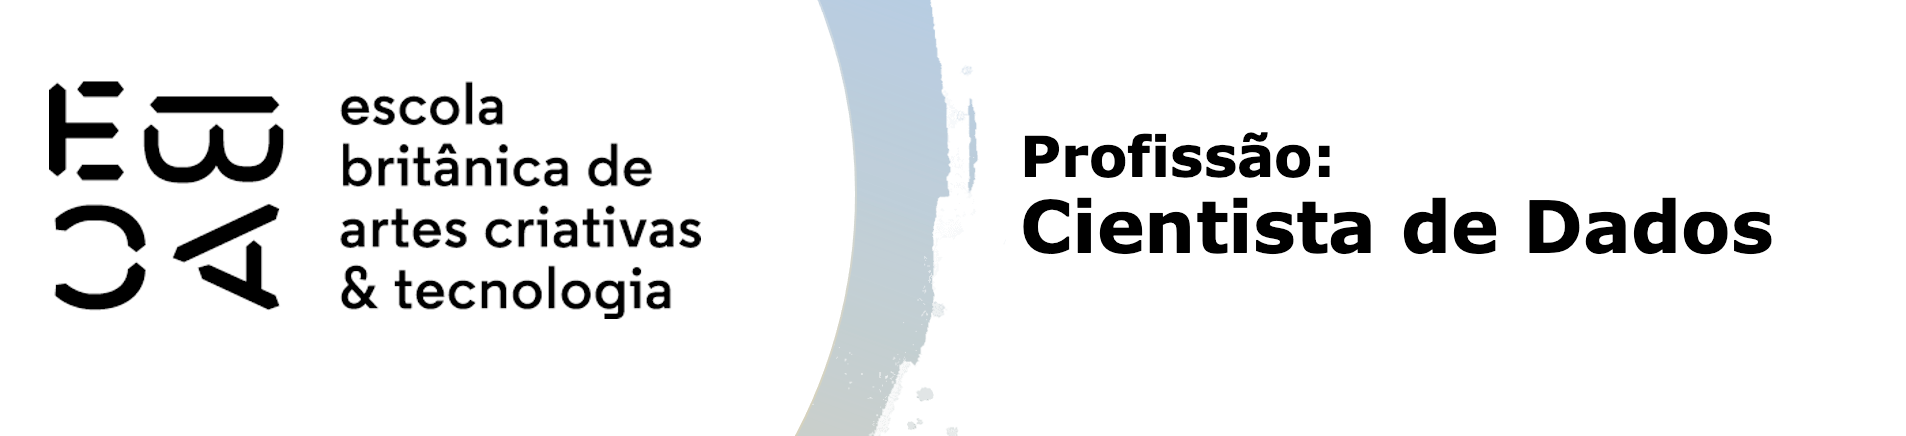

# Regressão III - Tarefa

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.interpolate import interp1d
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./input/previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 2015-01-01 to 2016-03-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   index                  750000 non-null  int64  
 1   sexo                   750000 non-null  object 
 2   posse_de_veiculo       750000 non-null  object 
 3   posse_de_imovel        750000 non-null  object 
 4   qtd_filhos             750000 non-null  int64  
 5   tipo_renda             750000 non-null  object 
 6   educacao               750000 non-null  object 
 7   estado_civil           750000 non-null  object 
 8   tipo_residencia        750000 non-null  object 
 9   idade                  750000 non-null  int64  
 10  tempo_emprego          624240 non-null  float64
 11  qt_pessoas_residencia  750000 non-null  float64
 12  renda                  750000 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


In [4]:
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
dtype: int64

In [5]:
df['tempo_emprego_mean'] = df['tempo_emprego'].fillna(value=df['tempo_emprego'].mean())
df['renda_log'] = np.log(df['renda'])
df.isna().sum()

index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125760
qt_pessoas_residencia         0
renda                         0
tempo_emprego_mean            0
renda_log                     0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [6]:
df.index = pd.to_datetime(df.index)
ultimos_meses = [mes for mes in df[df.index > (df.index.unique().max() - pd.DateOffset(months=3))].index.unique().strftime('%b%y')]

print(f'Três últimos meses da base:\n {", ".join(ultimos_meses)}')

Três últimos meses da base:
 Jan16, Feb16, Mar16


In [7]:
data_limite = df.index.max() - pd.DateOffset(months=3)
df_holdout = df[df.index > data_limite].copy()
df_holdout

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_mean,renda_log
data_ref,,,,,,,,,,,,,,,
2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,NaN,2.0,2137.61,7.746165,7.667444
2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.301370,9.538518
2016-01-01,16279,F,S,S,3,Assalariado,Médio,Casado,Casa,38,10.967123,5.0,11042.47,10.967123,9.309504
2016-01-01,8158,M,S,S,3,Servidor público,Médio,Casado,Casa,35,5.553425,5.0,1333.82,5.553425,7.195802
2016-01-01,9356,F,S,N,0,Assalariado,Médio,Viúvo,Casa,63,9.265753,1.0,17633.03,9.265753,9.777529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-01,11611,F,N,S,1,Assalariado,Superior completo,Casado,Casa,29,8.665753,3.0,2930.40,8.665753,7.982894
2016-03-01,9144,F,N,S,0,Pensionista,Superior completo,Casado,Casa,65,NaN,2.0,4084.37,7.746165,8.314923
2016-03-01,16583,F,N,S,0,Assalariado,Superior completo,Casado,Casa,33,10.969863,2.0,4339.66,10.969863,8.375551


In [8]:
df_train = df[df.index < data_limite].copy()
df_train

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_mean,renda_log
data_ref,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16.717808,9.318131
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,9.600000,7.793508
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,8.208219,9.528769
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1.301370,7.767196
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1.254795,6.673020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,2386,M,S,S,2,Empresário,Médio,Casado,Casa,34,0.358904,4.0,3234.07,0.358904,8.081497
2015-11-01,16237,F,N,S,0,Empresário,Superior completo,Casado,Casa,46,2.542466,2.0,6154.98,2.542466,8.725017
2015-11-01,85,M,S,S,0,Assalariado,Superior completo,União,Casa,28,5.690411,2.0,1355.88,5.690411,7.212206


### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [9]:
mdl_1 = smf.ols(formula='renda_log ~ tempo_emprego_mean', data=df_train).fit()
print(f'R-quadrado ajustado: {mdl_1.rsquared_adj:.2%}')
mdl_1.summary()

R-quadrado ajustado: 42.20%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                 4.016e+05
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:19:01   Log-Likelihood:            -7.3586e+05
No. Observations:              550000   AIC:                         1.472e+06
Df Residuals:                  549998   BIC:                         1.472e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.3395      0.002   4149.987      0.000       8.336       8.343
tempo_emprego_mean     0.1291      0.000    633.688      0.000       0.129       0.129
==============================================================================
Omnibus:                      940.042   Durbin-Watson:                   1.288
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              922.828
Skew:                          -0.089   Prob(JB):                    4.08e-201
Kurtosis:                       2.907   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
mdl_2 = smf.ols(formula='renda_log ~ tempo_emprego_mean', data=df_holdout).fit()
print(f'R-quadrado ajustado: {mdl_2.rsquared_adj:.2%}')
mdl_2.summary()

R-quadrado ajustado: 52.16%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                 1.635e+05
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:19:01   Log-Likelihood:            -1.7066e+05
No. Observations:              150000   AIC:                         3.413e+05
Df Residuals:                  149998   BIC:                         3.413e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.0989      0.003   2252.228      0.000       7.093       7.105
tempo_emprego_mean     0.1293      0.000    404.381      0.000       0.129       0.130
==============================================================================
Omnibus:                       13.139   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.567
Skew:                           0.008   Prob(JB):                      0.00113
Kurtosis:                       3.043   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [11]:
n_quantis = 20

qnt = n_quantis

while pd.qcut(x=df_train['tempo_emprego'], q=qnt, duplicates='drop').nunique() < n_quantis:
    qnt += 1
    
df_train['cat_tempo_emprego'] = pd.qcut(x=df_train['tempo_emprego'], q=qnt, duplicates='drop', precision=0)

df_cat = (df_train
          .groupby(by='cat_tempo_emprego')
          .agg({'cat_tempo_emprego': [('Quantidade de observações', 'count')], 
                'renda_log': [('Média do log-renda', 'mean')], 
                'tempo_emprego': [('Média do tempo de emprego', 'mean')]})
          .droplevel(level=0, axis=1))

df_cat

,Quantidade de observações,Média do log-renda,Média do tempo de emprego
cat_tempo_emprego,,,
"(0.0, 0.7]",23100,8.430249,0.463954
"(0.7, 1.2]",22931,8.478397,0.971819
"(1.2, 1.8]",22833,8.592335,1.502766
"(1.8, 2.4]",22728,8.623186,2.055116
"(2.4, 3.0]",23050,8.736564,2.716712
"(3.0, 3.6]",22716,8.816070,3.355774
"(3.6, 4.2]",23208,8.919439,3.929488
"(4.2, 4.7]",22685,8.967982,4.454245
"(4.7, 5.4]",22871,9.009809,5.007508


In [12]:
print(df_cat.columns)

Index(['Quantidade de observações', 'Média do log-renda',
       'Média do tempo de emprego'],
      dtype='object')


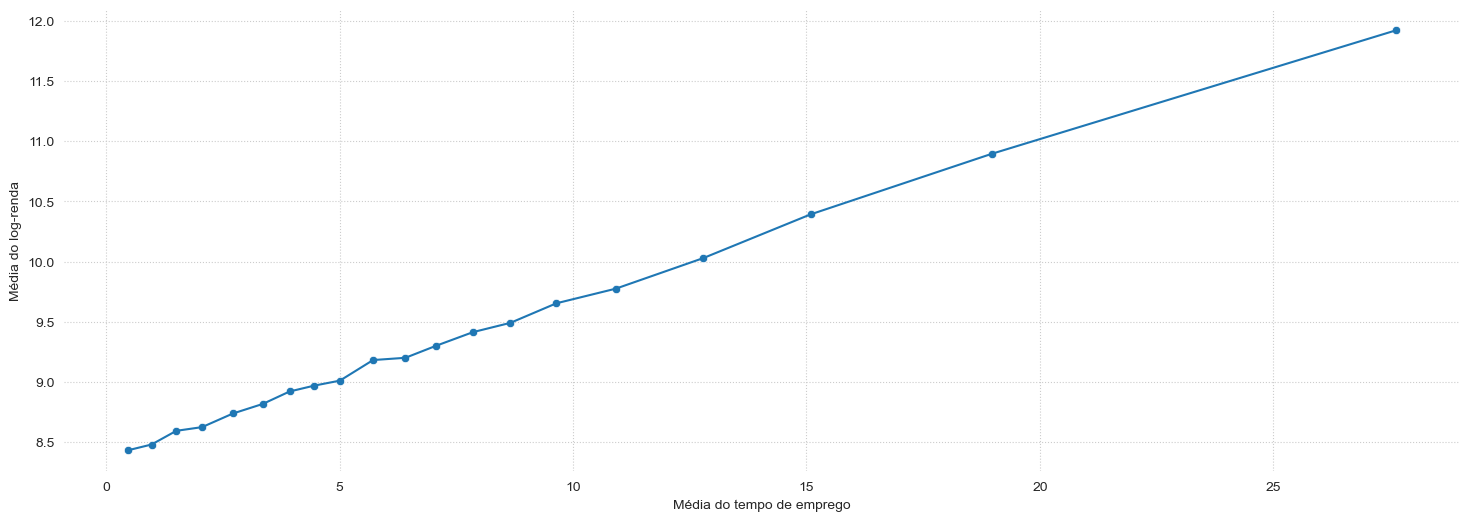

In [13]:
sns.set_style('whitegrid', {'grid_color': '.7', 'grid.linestyle': ':'})
plt.figure(figsize=(18,6))

sns.scatterplot(x='Média do tempo de emprego', y='Média do log-renda', data=df_cat)
sns.lineplot(x='Média do tempo de emprego', y='Média do log-renda', data=df_cat)
sns.despine(left=True, bottom=True)

plt.show()

Ao analisar o gráfico, percebe-se rapidamente uma tendência linear constante, sugerindo inicialmente o uso de uma regressão linear simples. No entanto, é crucial lembrar da transformação logarítmica na variável dependente, que, se utilizada originalmente, evidenciaria o crescimento exponencial, como demonstrado pelo espaçamento crescente entre os valores à medida que aumentam. Assim, considera-se que tanto a categorização quanto a transformação logarítmica ou a regressão segmentada podem fornecer resultados satisfatórios. Contudo, o método Lowess pode ser a melhor escolha devido à sua capacidade de se ajustar ao formato exponencial, suavizando a curva de acordo com a necessidade.

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [14]:
df_train['cat_renda'], retbins = pd.qcut(x=df_train.renda, q=20, retbins=True, precision=0)

print(f'''Quantidade de categorias para 'cat_renda': {df_train.cat_renda.nunique()}''')

df_train

Quantidade de categorias para 'cat_renda': 20


,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_mean,renda_log,cat_tempo_emprego,cat_renda
data_ref,,,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16.717808,9.318131,"(16.5, 21.5]","(10619.0, 12243.0]"
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,9.600000,7.793508,"(9.1, 10.2]","(1796.0, 2618.0]"
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,8.208219,9.528769,"(7.5, 8.2]","(12243.0, 14151.0]"
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1.301370,7.767196,"(1.2, 1.8]","(1796.0, 2618.0]"
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1.254795,6.673020,"(1.2, 1.8]","(140.0, 1796.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,2386,M,S,S,2,Empresário,Médio,Casado,Casa,34,0.358904,4.0,3234.07,0.358904,8.081497,"(0.0, 0.7]","(2618.0, 3394.0]"
2015-11-01,16237,F,N,S,0,Empresário,Superior completo,Casado,Casa,46,2.542466,2.0,6154.98,2.542466,8.725017,"(2.4, 3.0]","(5946.0, 6927.0]"
2015-11-01,85,M,S,S,0,Assalariado,Superior completo,União,Casa,28,5.690411,2.0,1355.88,5.690411,7.212206,"(5.4, 6.0]","(140.0, 1796.0]"


In [15]:
df_cat2 = (df_train
           .groupby(by='cat_renda')
           .agg({'cat_renda':[('Quantidade de observações', 'count')], 
                 'tempo_emprego': [('Média do tempo de emprego', 'mean')], 
                 'renda_log': [('Média do renda_log', 'mean')]})
           .droplevel(level=0, axis=1))

df_cat2

,Quantidade de observações,Média do tempo de emprego,Média do renda_log
cat_renda,,,
"(140.0, 1796.0]",27503,2.849764,7.065138
"(1796.0, 2618.0]",27500,3.528437,7.697416
"(2618.0, 3394.0]",27499,3.891346,8.005806
"(3394.0, 4188.0]",27505,4.247501,8.238149
"(4188.0, 5020.0]",27497,4.574378,8.432676
"(5020.0, 5946.0]",27498,4.791588,8.607090
"(5946.0, 6927.0]",27499,5.071390,8.767893
"(6927.0, 8020.0]",27503,5.318962,8.917020
"(8020.0, 9238.0]",27496,5.599144,9.060903


In [16]:
df_train['tempo_emprego_fillna_2'] = (df_train['tempo_emprego']
                                      .fillna(value=df_train.merge(right=df_cat2, 
                                                                   how='left', 
                                                                   left_on='cat_renda', 
                                                                   right_index=True)['Média do tempo de emprego']))

df_train

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_mean,renda_log,cat_tempo_emprego,cat_renda,tempo_emprego_fillna_2
data_ref,,,,,,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,16.717808,9.318131,"(16.5, 21.5]","(10619.0, 12243.0]",16.717808
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,9.600000,7.793508,"(9.1, 10.2]","(1796.0, 2618.0]",9.600000
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,8.208219,9.528769,"(7.5, 8.2]","(12243.0, 14151.0]",8.208219
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,1.301370,7.767196,"(1.2, 1.8]","(1796.0, 2618.0]",1.301370
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,1.254795,6.673020,"(1.2, 1.8]","(140.0, 1796.0]",1.254795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-11-01,2386,M,S,S,2,Empresário,Médio,Casado,Casa,34,0.358904,4.0,3234.07,0.358904,8.081497,"(0.0, 0.7]","(2618.0, 3394.0]",0.358904
2015-11-01,16237,F,N,S,0,Empresário,Superior completo,Casado,Casa,46,2.542466,2.0,6154.98,2.542466,8.725017,"(2.4, 3.0]","(5946.0, 6927.0]",2.542466
2015-11-01,85,M,S,S,0,Assalariado,Superior completo,União,Casa,28,5.690411,2.0,1355.88,5.690411,7.212206,"(5.4, 6.0]","(140.0, 1796.0]",5.690411


In [17]:
modelo2 = smf.ols(formula='renda_log ~ tempo_emprego_fillna_2', data=df_train).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 

modelo2.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                 5.071e+05
Date:                Mon, 13 Jan 2025   Prob (F-statistic):               0.00
Time:                        19:19:02   Log-Likelihood:            -7.0692e+05
No. Observations:              550000   AIC:                         1.414e+06
Df Residuals:                  549998   BIC:                         1.414e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.3253      0.002   4500.959      0.000       8.322       8.329
tempo_emprego_fillna_2     0.1352      0.000    712.140      0.000       0.135       0.136
==============================================================================
Omnibus:                      942.609   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              955.117
Skew:                          -0.095   Prob(JB):                    3.97e-208
Kurtosis:                       3.075   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
mdl_3 = smf.ols(formula='Q("Média do renda_log") ~ Q("Média do tempo de emprego")', data=df_cat2).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 3): {mdl_3.rsquared_adj:.2%}') 

mdl_3.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%
R-quadrado ajustado (modelo 3): 84.52%


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Q("Média do renda_log")   R-squared:                       0.853
Model:                                 OLS   Adj. R-squared:                  0.845
Method:                      Least Squares   F-statistic:                     104.7
Date:                     Mon, 13 Jan 2025   Prob (F-statistic):           6.26e-09
Time:                             19:19:02   Log-Likelihood:                -12.804
No. Observations:                       20   AIC:                             29.61
Df Residuals:                           18   BIC:                             31.60
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          7.5177      0.208     36.082      0.000       7.080       7.955
Q("Média do tempo de emprego")     0.2429      0.024     10.233      0.000       0.193       0.293
==============================================================================
Omnibus:                        5.157   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                3.700
Skew:                          -1.053   Prob(JB):                        0.157
Kurtosis:                       3.080   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
df_mdl_3 = (df_cat2
              .merge(right=mdl_3.get_prediction().summary_frame(), 
                     on='cat_renda')
              .rename(columns={'Quantidade de observações':'qtd', 
                               'Média do tempo de emprego':'tempo_emprego', 
                               'Média do renda_log':'renda_log'}))

df_mdl_3

,qtd,tempo_emprego,renda_log,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
cat_renda,,,,,,,,,
"(140.0, 1796.0]",27503,2.849764,7.065138,8.209909,0.154587,7.885133,8.534685,7.142844,9.276973
"(1796.0, 2618.0]",27500,3.528437,7.697416,8.374748,0.143524,8.073216,8.676280,7.314527,9.434969
"(2618.0, 3394.0]",27499,3.891346,8.005806,8.462893,0.138016,8.172932,8.752854,7.405905,9.519881
"(3394.0, 4188.0]",27505,4.247501,8.238149,8.549397,0.132932,8.270118,8.828677,7.495289,9.603506
"(4188.0, 5020.0]",27497,4.574378,8.432676,8.628791,0.128578,8.358658,8.898923,7.577069,9.680513
"(5020.0, 5946.0]",27498,4.791588,8.607090,8.681548,0.125867,8.417112,8.945984,7.631275,9.731821
"(5946.0, 6927.0]",27499,5.071390,8.767893,8.749507,0.122605,8.491924,9.007091,7.700939,9.798076
"(6927.0, 8020.0]",27503,5.318962,8.917020,8.809639,0.119952,8.557629,9.061648,7.762425,9.856852
"(8020.0, 9238.0]",27496,5.599144,9.060903,8.877691,0.117232,8.631394,9.123987,7.831838,9.923544


In [20]:
def plotar_resultados_regressao(data: pd.DataFrame) -> None:
    """
    Plota os dados observados, a média prevista e os intervalos de confiança de um modelo de regressão.

    Parâmetros:
        data (pd.DataFrame): DataFrame contendo os resultados da regressão.

    Retorna:
        None
    """
    plt.figure(figsize=(18, 6))

    sns.set_theme(style='white')

    plt.plot(data['tempo_emprego'], data['renda_log'], 'bo', alpha=.9, label='Dados observados')
    plt.plot(data['tempo_emprego'], data['renda_log'], '-', alpha=.3)
    plt.plot(data['tempo_emprego'], data['mean'], 'g-.', label='Média prevista')
    plt.plot(data['tempo_emprego'], data['mean_ci_lower'], ':', color='orange', label='Intervalo de confiança da média')
    plt.plot(data['tempo_emprego'], data['mean_ci_upper'], ':', color='orange')
    plt.plot(data['tempo_emprego'], data['obs_ci_lower'], 'r--', label='Intervalo de confiança para a variável de resposta')
    plt.plot(data['tempo_emprego'], data['obs_ci_upper'], 'r--')

    plt.legend(loc='best')

    plt.show()

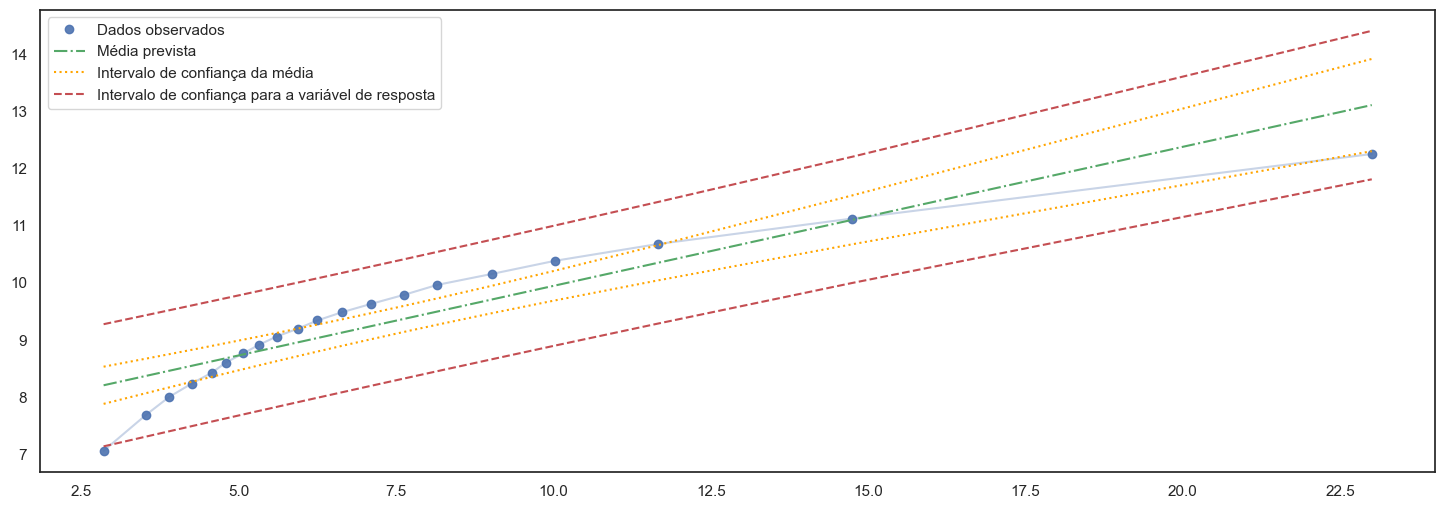

In [21]:
plotar_resultados_regressao(data=df_mdl_3)

In [47]:
df_train2 = (df_cat2
             .iloc[:,1:]
             .reset_index(drop=True)
             .rename(columns={'Média do tempo de emprego':'tempo_emprego', 'Média do renda_log':'renda_log'}))
df_train2

,tempo_emprego,renda_log
0,2.849764,7.065138
1,3.528437,7.697416
2,3.891346,8.005806
3,4.247501,8.238149
4,4.574378,8.432676
5,4.791588,8.607090
6,5.071390,8.767893
7,5.318962,8.917020
8,5.599144,9.060903
9,5.942000,9.201319


In [23]:
df_train2['tempo_emprego_cat'], q = pd.qcut(x=df_train2.tempo_emprego, q=10, retbins=True, duplicates='drop')

q

array([ 2.84976397,  3.85505533,  4.50900231,  4.9874492 ,  5.48707113,
        6.09309743,  6.82148659,  7.78649004,  9.22449071, 11.97248192,
       23.00445393])

In [24]:
q = [-np.inf, #2.84976397, 
     3.85505533, 
     4.50900231, 
#      4.9874492, 
     5.48707113, 
#      6.09309743, 
     6.82148659, 
#      7.78649004, 
     9.22449071, 
#      11.97248192, 
     np.inf #23.00445393
    ]

df_train2['tempo_emprego_cat'] = pd.cut(x=df_train2.tempo_emprego, bins=q)
df_train3 = pd.DataFrame()
df_train3['y_mean'] = df_train2.groupby(by='tempo_emprego_cat')['renda_log'].mean()

std_error = df_train2.groupby(by='tempo_emprego_cat')['renda_log'].sem()

df_train3['y_max'] = df_train3['y_mean'] + std_error * 2
df_train3['y_min'] = df_train3['y_mean'] - std_error * 2

df_train3 = df_train2.merge(right=df_train3, how='left', left_on='tempo_emprego_cat', right_index=True)

df_train3

,tempo_emprego,renda_log,tempo_emprego_cat,y_mean,y_max,y_min
0,2.849764,7.065138,"(-inf, 3.855]",7.381277,8.013554,6.748999
1,3.528437,7.697416,"(-inf, 3.855]",7.381277,8.013554,6.748999
2,3.891346,8.005806,"(3.855, 4.509]",8.121978,8.354321,7.889634
3,4.247501,8.238149,"(3.855, 4.509]",8.121978,8.354321,7.889634
4,4.574378,8.432676,"(4.509, 5.487]",8.681170,8.889643,8.472696
5,4.791588,8.607090,"(4.509, 5.487]",8.681170,8.889643,8.472696
6,5.071390,8.767893,"(4.509, 5.487]",8.681170,8.889643,8.472696
7,5.318962,8.917020,"(4.509, 5.487]",8.681170,8.889643,8.472696
8,5.599144,9.060903,"(5.487, 6.821]",9.272086,9.454290,9.089883
9,5.942000,9.201319,"(5.487, 6.821]",9.272086,9.454290,9.089883


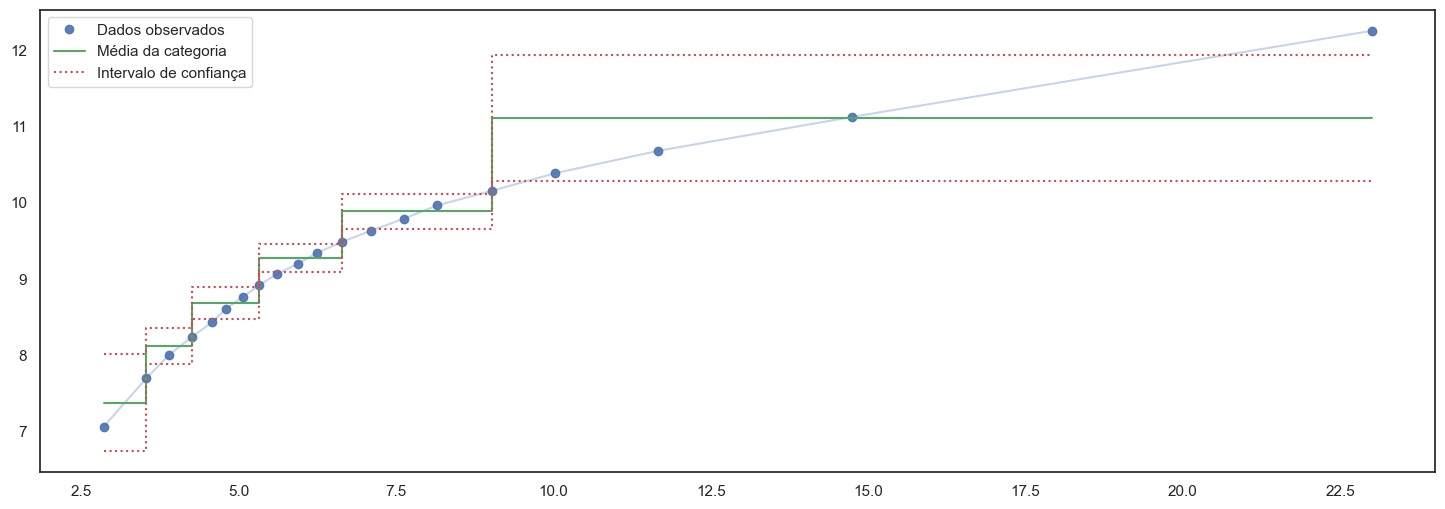

In [25]:
plt.figure(figsize=(18,6))
plt.plot(df_train3.tempo_emprego, df_train3.renda_log, 'bo', alpha=.9, label='Dados observados')
plt.plot(df_train3.tempo_emprego, df_train3.renda_log, '-', alpha=.3)
plt.step(df_train3.tempo_emprego, df_train3.y_mean, 'g-', label='Média da categoria')
plt.step(df_train3.tempo_emprego, df_train3.y_max, 'r:', label='Intervalo de confiança')
plt.step(df_train3.tempo_emprego, df_train3.y_min, 'r:')
plt.legend(loc='best')

plt.show()

In [26]:
mdl_4 = smf.ols(formula='renda_log ~ tempo_emprego_cat', data=df_train3).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 3): {mdl_3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 4): {mdl_4.rsquared_adj:.2%}') 

mdl_4.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%
R-quadrado ajustado (modelo 3): 84.52%
R-quadrado ajustado (modelo 4): 87.60%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     27.85
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           8.34e-07
Time:                        19:19:02   Log-Likelihood:                -8.0667
No. Observations:                  20   AIC:                             28.13
Df Residuals:                      14   BIC:                             34.11
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       7.3813      0.306     24.114      0.000       6.725       8.038
tempo_emprego_cat[T.Interval(3.855, 4.509, closed='right')]     0.7407      0.433      1.711      0.109      -0.188       1.669
tempo_emprego_cat[T.Interval(4.509, 5.487, closed='right')]     1.2999      0.375      3.467      0.004       0.496       2.104
tempo_emprego_cat[T.Interval(5.487, 6.821, closed='right')]     1.8908      0.375      5.044      0.000       1.087       2.695
tempo_emprego_cat[T.Interval(6.821, 9.224, closed='right')]     2.5046      0.375      6.681      0.000       1.701       3.309
tempo_emprego_cat[T.Interval(9.224, inf, closed='right')]       3.7274      0.375      9.942      0.000       2.923       4.531
==============================================================================
Omnibus:                       11.680   Durbin-Watson:                   1.512
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.165
Skew:                           1.081   Prob(JB):                      0.00376
Kurtosis:                       5.954   Cond. No.                         8.74
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

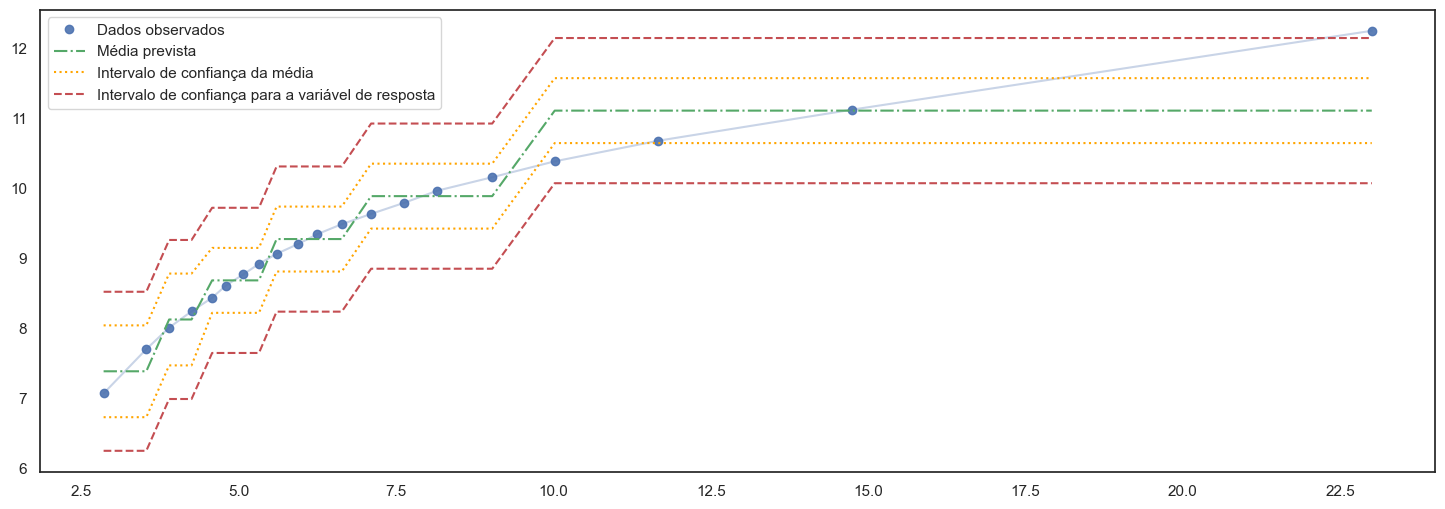

In [27]:
df_mdl_4 = pd.concat(objs=[df_train3, mdl_4.get_prediction().summary_frame()], axis=1)

plotar_resultados_regressao(data=df_mdl_4)

In [28]:
mdl_5 = smf.ols(formula='renda_log ~ I(np.log(tempo_emprego))', data=df_train2).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 3): {mdl_3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 4): {mdl_4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 5): {mdl_5.rsquared_adj:.2%}') 

mdl_5.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%
R-quadrado ajustado (modelo 3): 84.52%
R-quadrado ajustado (modelo 4): 87.60%
R-quadrado ajustado (modelo 5): 99.14%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2190.
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           2.96e-20
Time:                        19:19:03   Log-Likelihood:                 16.097
No. Observations:                  20   AIC:                            -28.19
Df Residuals:                      18   BIC:                            -26.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.7771      0.101     47.401      0.000       4.565       4.989
I(np.log(tempo_emprego))     2.4268      0.052     46.798      0.000       2.318       2.536
==============================================================================
Omnibus:                        2.861   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.293
Skew:                          -0.796   Prob(JB):                        0.318
Kurtosis:                       2.532   Cond. No.                         9.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
df_mdl_5 = pd.concat(objs=[df_train2.iloc[:,:2], mdl_5.get_prediction().summary_frame().reset_index(drop=True)], axis=1)
df_mdl_5

,tempo_emprego,renda_log,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.849764,7.065138,7.318549,0.050160,7.213168,7.423930,7.056784,7.580314
1,3.528437,7.697416,7.836967,0.041009,7.750810,7.923124,7.582332,8.091602
2,3.891346,8.005806,8.074555,0.037168,7.996468,8.152641,7.822536,8.326573
3,4.247501,8.238149,8.287086,0.034007,8.215640,8.358533,8.037046,8.537127
4,4.574378,8.432676,8.467012,0.031596,8.400632,8.533392,8.218371,8.715652
5,4.791588,8.607090,8.579596,0.030238,8.516068,8.643123,8.331702,8.827490
6,5.071390,8.767893,8.717326,0.028764,8.656895,8.777757,8.470207,8.964445
7,5.318962,8.917020,8.832997,0.027708,8.774785,8.891208,8.586411,9.079582
8,5.599144,9.060903,8.957580,0.026779,8.901319,9.013841,8.711448,9.203712
9,5.942000,9.201319,9.101812,0.026005,9.047177,9.156447,8.856046,9.347577


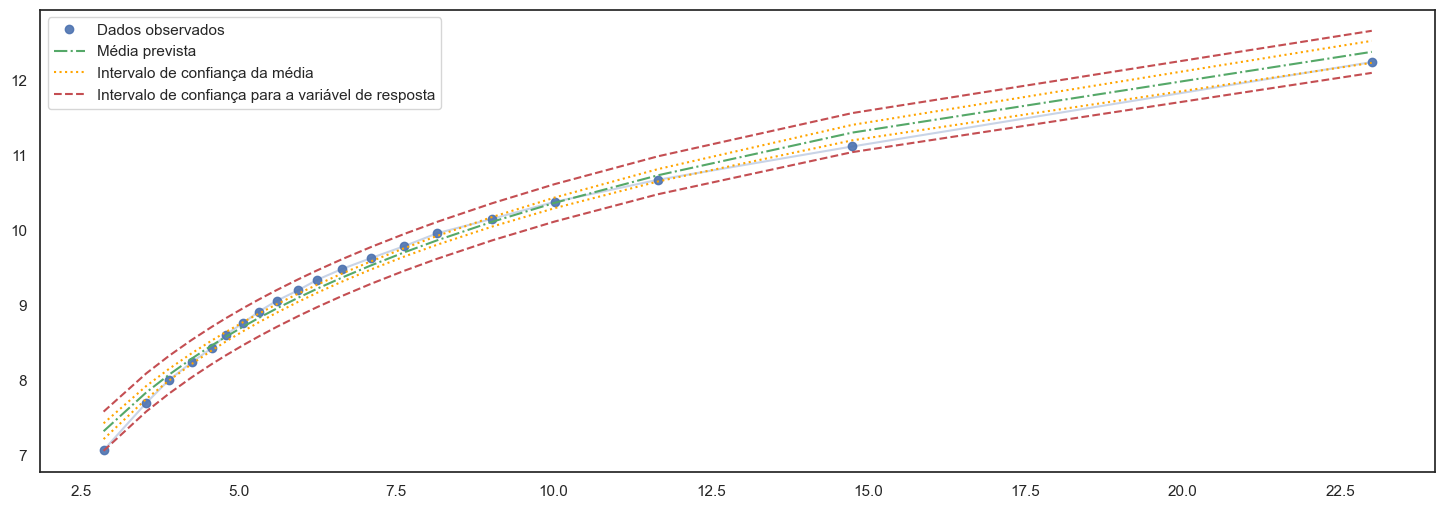

In [30]:
plotar_resultados_regressao(data=df_mdl_5)

In [31]:
C1 = 7.5

df_train2['X_1'] = (df_train2['tempo_emprego'] <= C1) * df_train2['tempo_emprego'] + (df_train2['tempo_emprego'] > C1) * C1
df_train2['X_2'] = (df_train2['tempo_emprego'] > C1) * df_train2['tempo_emprego'] + (df_train2['tempo_emprego'] <= C1) * C1

df_train2

,tempo_emprego,renda_log,tempo_emprego_cat,X_1,X_2
0,2.849764,7.065138,"(-inf, 3.855]",2.849764,7.500000
1,3.528437,7.697416,"(-inf, 3.855]",3.528437,7.500000
2,3.891346,8.005806,"(3.855, 4.509]",3.891346,7.500000
3,4.247501,8.238149,"(3.855, 4.509]",4.247501,7.500000
4,4.574378,8.432676,"(4.509, 5.487]",4.574378,7.500000
5,4.791588,8.607090,"(4.509, 5.487]",4.791588,7.500000
6,5.071390,8.767893,"(4.509, 5.487]",5.071390,7.500000
7,5.318962,8.917020,"(4.509, 5.487]",5.318962,7.500000
8,5.599144,9.060903,"(5.487, 6.821]",5.599144,7.500000
9,5.942000,9.201319,"(5.487, 6.821]",5.942000,7.500000


In [32]:
mdl_6 = smf.ols(formula='renda_log ~ X_1 + X_2', data=df_train2).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 3): {mdl_3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 4): {mdl_4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 5): {mdl_5.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 6): {mdl_6.rsquared_adj:.2%}') 

mdl_6.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%
R-quadrado ajustado (modelo 3): 84.52%
R-quadrado ajustado (modelo 4): 87.60%
R-quadrado ajustado (modelo 5): 99.14%
R-quadrado ajustado (modelo 6): 98.82%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     799.8
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           1.53e-17
Time:                        19:19:03   Log-Likelihood:                 13.550
No. Observations:                  20   AIC:                            -21.10
Df Residuals:                      17   BIC:                            -18.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7008      0.123     38.364      0.000       4.442       4.959
X_1            0.5560      0.022     25.166      0.000       0.509       0.603
X_2            0.1486      0.009     16.300      0.000       0.129       0.168
==============================================================================
Omnibus:                        6.489   Durbin-Watson:                   0.466
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.254
Skew:                          -1.082   Prob(JB):                        0.119
Kurtosis:                       3.647   Cond. No.                         47.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
df_mdl_6 = pd.concat(objs=[df_train2.iloc[:,[0,1,3,4]], mdl_6.get_prediction().summary_frame()], axis=1)

df_mdl_6

,tempo_emprego,renda_log,X_1,X_2,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.849764,7.065138,2.849764,7.500000,7.399854,0.069244,7.253762,7.545947,7.082947,7.716762
1,3.528437,7.697416,3.528437,7.500000,7.777194,0.056441,7.658113,7.896275,7.471797,8.082592
2,3.891346,8.005806,3.891346,7.500000,7.978971,0.050097,7.873276,8.084666,7.678540,8.279402
3,4.247501,8.238149,4.247501,7.500000,8.176992,0.044400,8.083317,8.270667,7.880576,8.473408
4,4.574378,8.432676,4.574378,7.500000,8.358734,0.039827,8.274706,8.442762,8.065224,8.652244
5,4.791588,8.607090,4.791588,7.500000,8.479502,0.037256,8.400900,8.558105,8.187500,8.771505
6,5.071390,8.767893,5.071390,7.500000,8.635071,0.034648,8.561970,8.708173,8.344501,8.925642
7,5.318962,8.917020,5.318962,7.500000,8.772720,0.033141,8.702798,8.842643,8.482933,9.062507
8,5.599144,9.060903,5.599144,7.500000,8.928501,0.032480,8.859975,8.997028,8.639048,9.217954
9,5.942000,9.201319,5.942000,7.500000,9.119128,0.033258,9.048960,9.189295,8.829282,9.408974


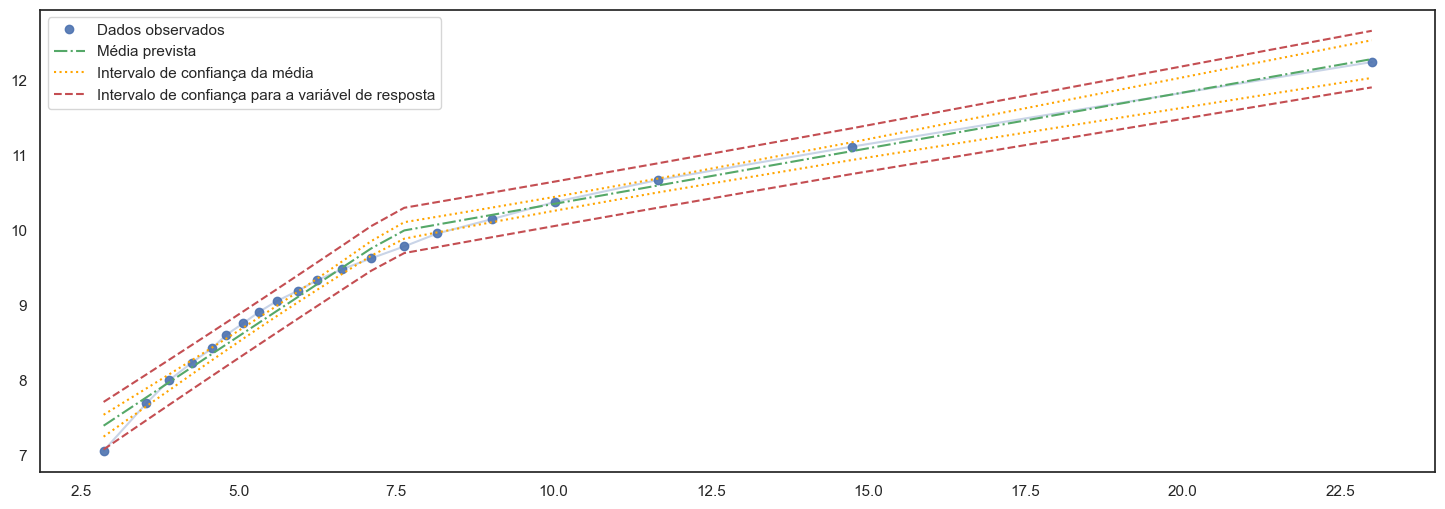

In [34]:
plotar_resultados_regressao(data=df_mdl_6)

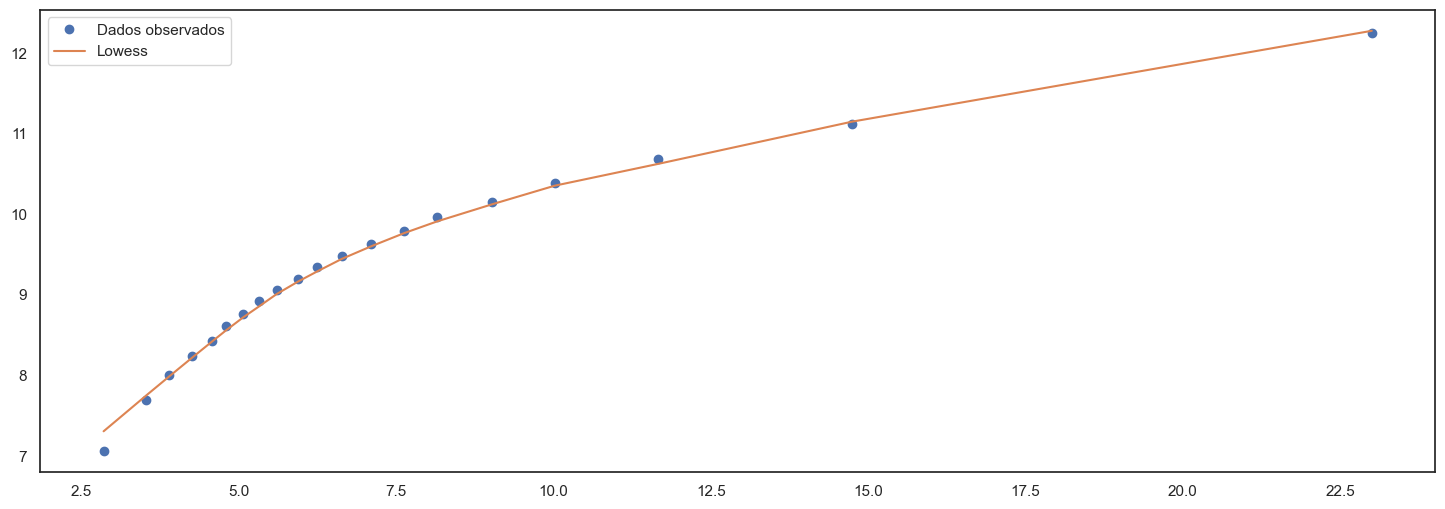

In [35]:
lowess = sm.nonparametric.lowess(endog=df_train2['renda_log'], exog=df_train2['tempo_emprego'], frac=2/3)

plt.figure(figsize=(18,6))
plt.plot(df_train2['tempo_emprego'], df_train2['renda_log'], 'o', label='Dados observados')
plt.plot(df_train2['tempo_emprego'], lowess[:,1], label='Lowess')
plt.legend()

plt.show()

In [36]:
f = interp1d(x=lowess[:,0], y=lowess[:,1], bounds_error=False)

df_train2['lowess'] = f(df_train2['tempo_emprego'])

df_train2

,tempo_emprego,renda_log,tempo_emprego_cat,X_1,X_2,lowess
0,2.849764,7.065138,"(-inf, 3.855]",2.849764,7.500000,7.307218
1,3.528437,7.697416,"(-inf, 3.855]",3.528437,7.500000,7.752347
2,3.891346,8.005806,"(3.855, 4.509]",3.891346,7.500000,7.986832
3,4.247501,8.238149,"(3.855, 4.509]",4.247501,7.500000,8.214564
4,4.574378,8.432676,"(4.509, 5.487]",4.574378,7.500000,8.421189
5,4.791588,8.607090,"(4.509, 5.487]",4.791588,7.500000,8.556649
6,5.071390,8.767893,"(4.509, 5.487]",5.071390,7.500000,8.722038
7,5.318962,8.917020,"(4.509, 5.487]",5.318962,7.500000,8.855380
8,5.599144,9.060903,"(5.487, 6.821]",5.599144,7.500000,9.008673
9,5.942000,9.201319,"(5.487, 6.821]",5.942000,7.500000,9.164919


In [37]:
mdl_7 = smf.ols(formula='renda_log ~ lowess', data=df_train2).fit()

print(f'R-quadrado ajustado (modelo 1): {mdl_1.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 2): {mdl_2.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 3): {mdl_3.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 4): {mdl_4.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 5): {mdl_5.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 6): {mdl_6.rsquared_adj:.2%}') 
print(f'R-quadrado ajustado (modelo 7): {mdl_7.rsquared_adj:.2%}') 

mdl_7.summary()

R-quadrado ajustado (modelo 1): 42.20%
R-quadrado ajustado (modelo 2): 52.16%
R-quadrado ajustado (modelo 3): 84.52%
R-quadrado ajustado (modelo 4): 87.60%
R-quadrado ajustado (modelo 5): 99.14%
R-quadrado ajustado (modelo 6): 98.82%
R-quadrado ajustado (modelo 7): 99.71%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     6559.
Date:                Mon, 13 Jan 2025   Prob (F-statistic):           1.60e-24
Time:                        19:19:04   Log-Likelihood:                 27.011
No. Observations:                  20   AIC:                            -50.02
Df Residuals:                      18   BIC:                            -48.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1412      0.118     -1.197      0.247      -0.389       0.107
lowess         1.0166      0.013     80.987      0.000       0.990       1.043
==============================================================================
Omnibus:                       26.294   Durbin-Watson:                   0.634
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.722
Skew:                          -2.312   Prob(JB):                     1.44e-09
Kurtosis:                       8.242   Cond. No.                         75.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
df_mdl_7 = pd.concat(objs=[df_train2.iloc[:,[0,1,5]], mdl_7.get_prediction().summary_frame()], axis=1)

df_mdl_7

,tempo_emprego,renda_log,lowess,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.849764,7.065138,7.307218,7.287314,0.029338,7.225678,7.348950,7.135409,7.439219
1,3.528437,7.697416,7.752347,7.739834,0.024672,7.688001,7.791667,7.591635,7.888033
2,3.891346,8.005806,7.986832,7.978212,0.022384,7.931185,8.025239,7.831625,8.124799
3,4.247501,8.238149,8.214564,8.209725,0.020325,8.167025,8.252426,8.064469,8.354982
4,4.574378,8.432676,8.421189,8.419782,0.018640,8.380621,8.458942,8.275526,8.564037
5,4.791588,8.607090,8.556649,8.557490,0.017655,8.520399,8.594581,8.413783,8.701198
6,5.071390,8.767893,8.722038,8.725625,0.016610,8.690729,8.760521,8.582468,8.868782
7,5.318962,8.917020,8.855380,8.861182,0.015915,8.827745,8.894618,8.718373,9.003990
8,5.599144,9.060903,9.008673,9.017020,0.015305,8.984864,9.049175,8.874506,9.159533
9,5.942000,9.201319,9.164919,9.175859,0.014915,9.144524,9.207195,9.033528,9.318190


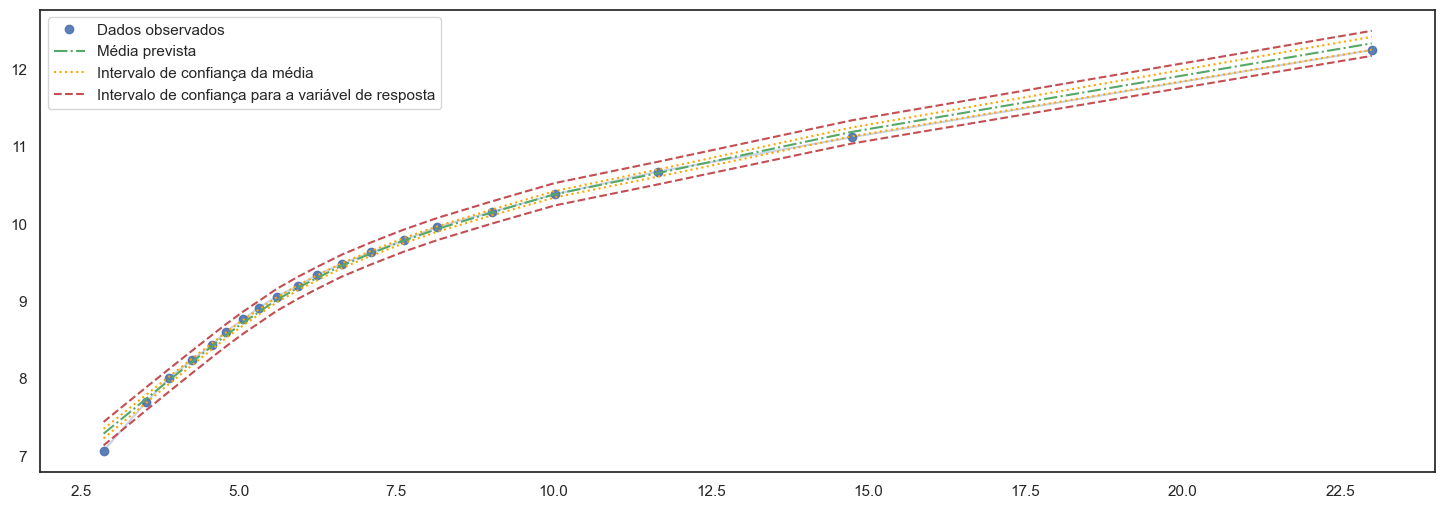

In [39]:
plotar_resultados_regressao(data=df_mdl_7)

In [40]:
print(df_train.dtypes)


index                        int64
sexo                        object
posse_de_veiculo            object
posse_de_imovel             object
qtd_filhos                   int64
tipo_renda                  object
educacao                    object
estado_civil                object
tipo_residencia             object
idade                        int64
tempo_emprego              float64
qt_pessoas_residencia      float64
renda                      float64
tempo_emprego_mean         float64
renda_log                  float64
cat_tempo_emprego         category
cat_renda                 category
tempo_emprego_fillna_2     float64
dtype: object


### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [41]:
df_train['tempo_emprego_fillna_2'] = pd.to_numeric(df_train['tempo_emprego_fillna_2'], errors='coerce')
df_train['renda_log'] = pd.to_numeric(df_train['renda_log'], errors='coerce')

df_train.dropna(subset=['tempo_emprego_fillna_2', 'renda_log'], inplace=True)

numeric_cols = df_train.select_dtypes(include=['number']).columns

df_ = (
    df_train
    .groupby(by=['data_ref', pd.cut(x=df_train['renda'], bins=retbins)])
    [numeric_cols]
    .mean()
    [['tempo_emprego_fillna_2', 'renda_log']]
    .reset_index(level='renda', drop=True)
    .rename(columns={'tempo_emprego_fillna_2': 'tempo_emprego'})
)

df_

,tempo_emprego,renda_log
data_ref,,
2015-01-01,3.194272,6.997679
2015-01-01,4.354972,7.689576
2015-01-01,5.014070,7.999606
2015-01-01,5.544035,8.233186
2015-01-01,6.225385,8.427393
...,...,...
2015-11-01,12.246510,10.160255
2015-11-01,13.739757,10.383573
2015-11-01,16.263401,10.688720


In [42]:
df_train_ = df_[df_.index <= df_.index.unique().max() - pd.DateOffset(months=3)].copy()
df_test_ = df_[~df_.index.isin(df_train_.index)].copy()

print(f'''
Base de treino: {df_train_.shape} - {df_train_.index.unique().strftime('%b%y').values}
Base de teste: {df_test_.shape} - {df_test_.index.unique().strftime('%b%y').values}
''')


Base de treino: (160, 2) - ['Jan15' 'Feb15' 'Mar15' 'Apr15' 'May15' 'Jun15' 'Jul15' 'Aug15']
Base de teste: (60, 2) - ['Sep15' 'Oct15' 'Nov15']



CATEGORIZAÇÃO
R-quadrado ajustado do modelo: 70.23%
R-quadrado com dados de teste: 81.51%



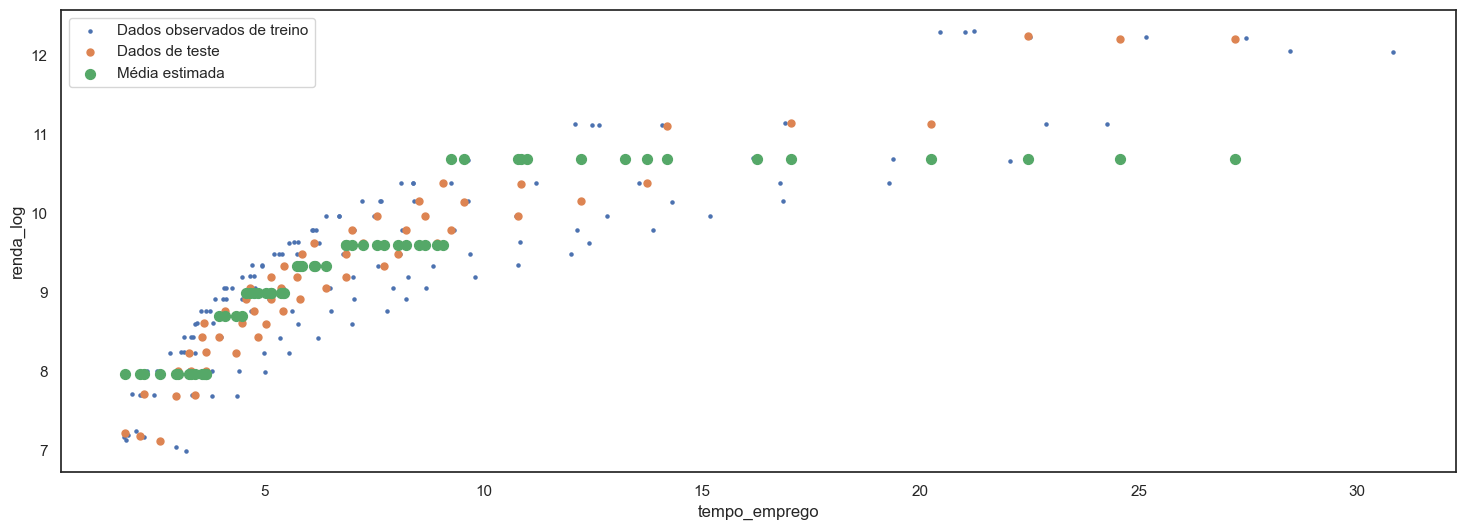

In [43]:
df_train_['tempo_emprego_cat'] = pd.cut(x=df_train_.tempo_emprego, bins=q)
df_test_['tempo_emprego_cat'] = pd.cut(x=df_test_.tempo_emprego, bins=q)

cat_model = smf.ols(formula='renda_log ~ tempo_emprego_cat', data=df_train_).fit()

print(f'''CATEGORIZAÇÃO
R-quadrado ajustado do modelo: {cat_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=cat_model.predict(df_test_)):.2%}
''')

def plotar_resultados_teste(modelo: sm.regression.linear_model.RegressionResultsWrapper) -> None:
    """
    Plota os dados observados de treinamento, os dados de teste e a média estimada pelo modelo.

    Parâmetros:
        modelo (sm.regression.linear_model.RegressionResultsWrapper): Modelo de regressão.

    Retorna:
        None
    """
    plt.figure(figsize=(18,6))
    plt.scatter(df_train_.tempo_emprego, df_train_.renda_log, s=5, label='Dados observados de treino')
    plt.scatter(df_test_.tempo_emprego, df_test_.renda_log, s=25, label='Dados de teste')
    plt.scatter(df_test_.tempo_emprego, modelo.predict(df_test_), s=50, label='Média estimada')
    plt.xlabel(xlabel='tempo_emprego')
    plt.ylabel(ylabel='renda_log')
    plt.legend(loc=2)
    plt.show()
    
plotar_resultados_teste(modelo=cat_model)

TRANSFORMAÇÃO SOBRE X
R-quadrado ajustado do modelo: 81.53%
R-quadrado com dados de teste: 93.34%



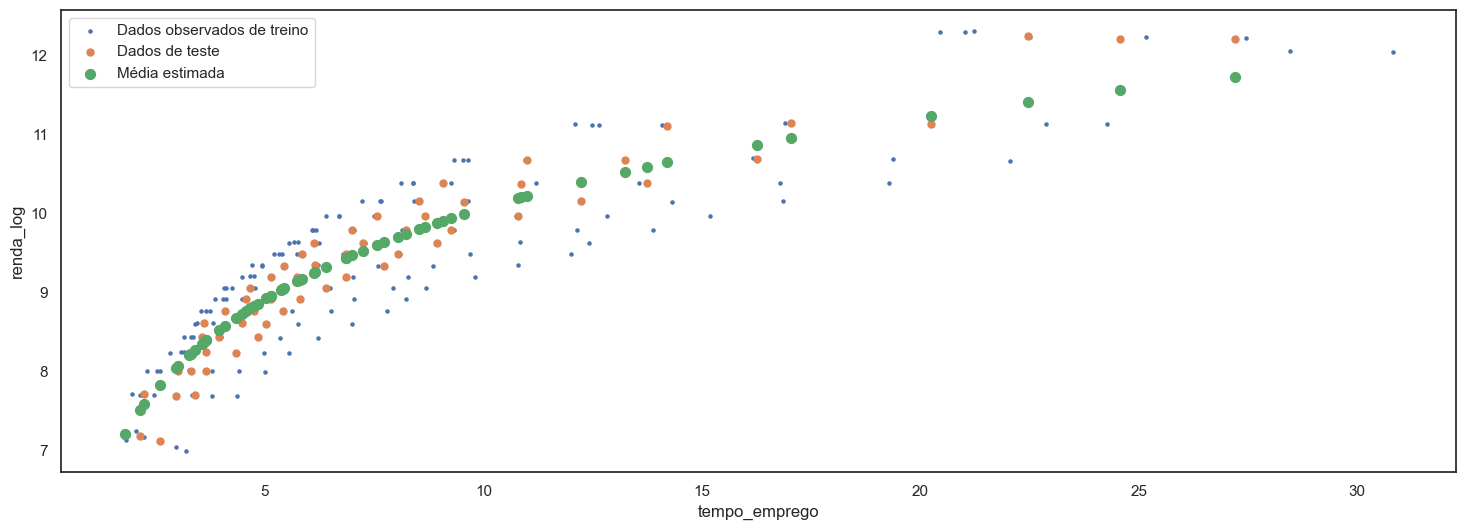

In [44]:
transform_model = smf.ols(formula='renda_log ~ I(np.log(tempo_emprego))', data=df_train_).fit()

r2 = r2_score(y_true=df_test_.renda_log, y_pred=transform_model.predict(df_test_))
print(f'''TRANSFORMAÇÃO SOBRE X
R-quadrado ajustado do modelo: {transform_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2:.2%}
''')

plotar_resultados_teste(modelo=transform_model)

REGRESSÃO SEGMENTADA
R-quadrado ajustado do modelo: 80.99%
R-quadrado com dados de teste: 93.07%



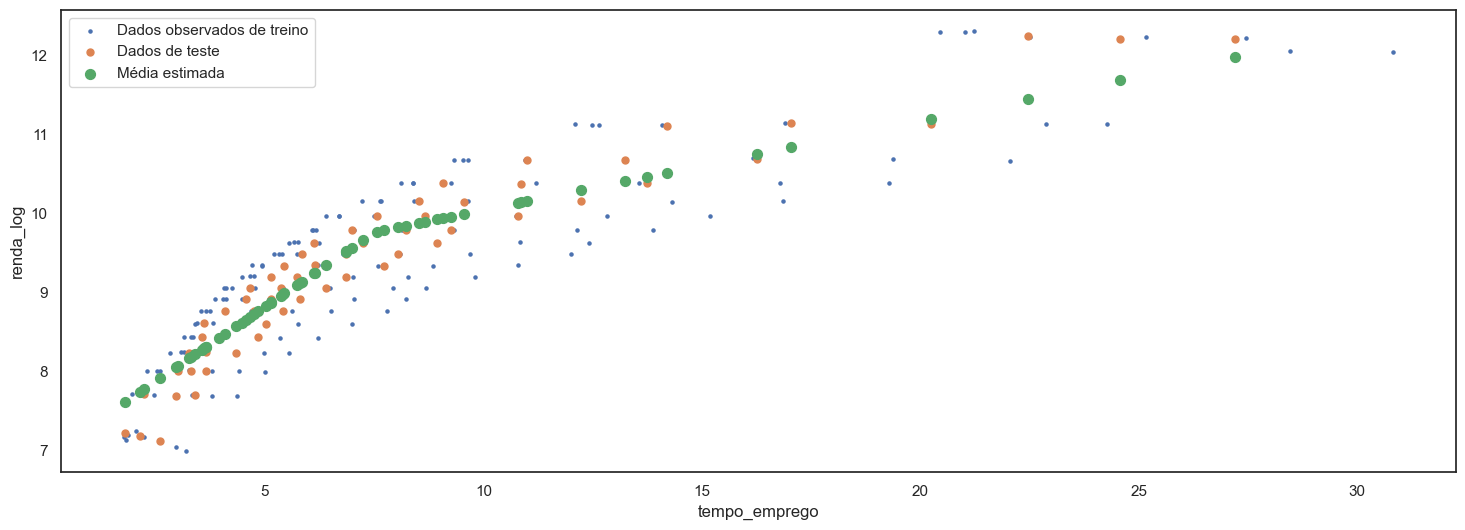

In [45]:
C1 = 7.5

df_train_['X_1'] = (df_train_['tempo_emprego'] <= C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] >  C1) * C1
df_train_['X_2'] = (df_train_['tempo_emprego'] >  C1) * df_train_['tempo_emprego'] + (df_train_['tempo_emprego'] <= C1) * C1

df_test_['X_1'] = (df_test_['tempo_emprego'] <= C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] >  C1) * C1
df_test_['X_2'] = (df_test_['tempo_emprego'] >  C1) * df_test_['tempo_emprego'] + (df_test_['tempo_emprego'] <= C1) * C1

segmented_model = smf.ols(formula='renda_log ~ X_1 + X_2', data=df_train_).fit()

print(f'''REGRESSÃO SEGMENTADA
R-quadrado ajustado do modelo: {segmented_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=segmented_model.predict(df_test_)):.2%}
''')

plotar_resultados_teste(modelo=segmented_model)

LOWESS
R-quadrado ajustado do modelo: 81.92%
R-quadrado com dados de teste: 93.57%



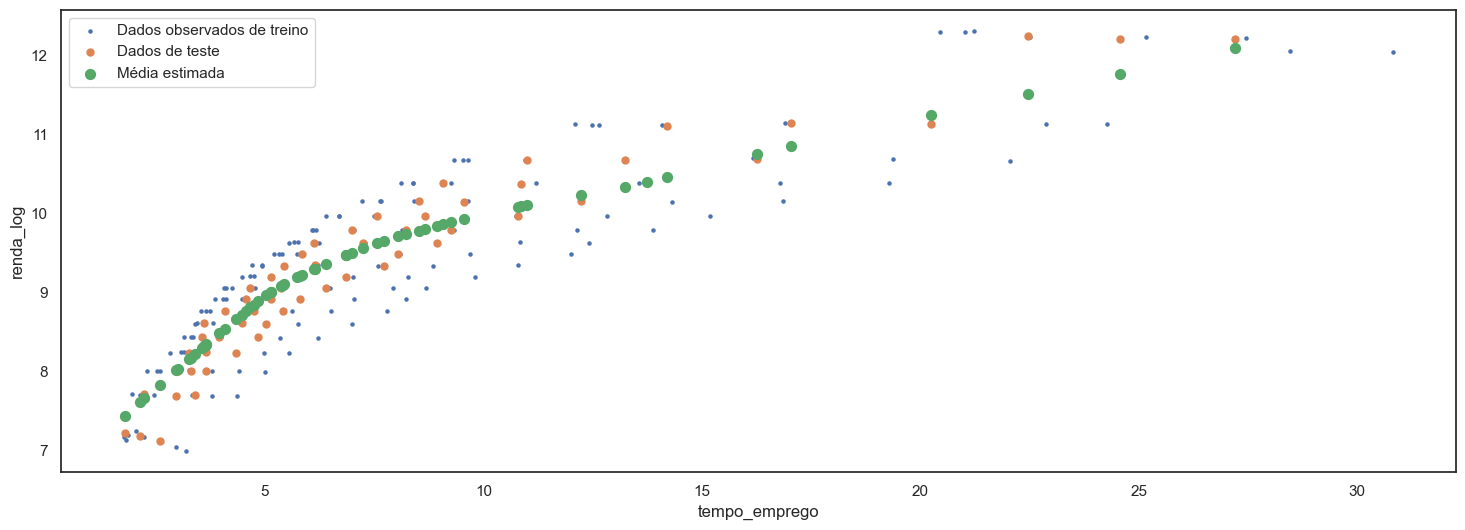

In [46]:
lowess_ = sm.nonparametric.lowess(endog=df_train_.renda_log, exog=df_train_.tempo_emprego, frac=2/3)

f_ = interp1d(x=lowess_[:,0], y=lowess_[:,1], bounds_error=False)

df_train_['lowess'] = f_(df_train_.tempo_emprego)
df_test_['lowess'] = f_(df_test_.tempo_emprego)

lowess_model = smf.ols(formula='renda_log ~ lowess', data=df_train_).fit()

print(f'''LOWESS
R-quadrado ajustado do modelo: {lowess_model.rsquared_adj:.2%}
R-quadrado com dados de teste: {r2_score(y_true=df_test_.renda_log, y_pred=lowess_model.predict(df_test_)):.2%}
''')

plotar_resultados_teste(modelo=lowess_model)